# 02 Boxes Processing

![](https://images.unsplash.com/photo-1513672494107-cd9d848a383e?ixlib=rb-1.2.1&auto=format&fit=crop&w=1050&q=80)

Photo by [chuttersnap](https://unsplash.com/photos/fyaTq-fIlro)

Now that have computed the object detection on two sample images, we will display the results, and process them if needed!

## I. Visualization

### I.1. Loading

First things first: load the images and the dictionaries saved in pickle format at the end of the last challenge.

In [4]:
### TODO: Load the pickle dicts and the images
### STRIP_START ###
import pickle

dict1 = pickle.load(open("../../01-Boxes-Computation/src/output_im1.p", "rb"))
dict2 = pickle.load(open("../../01-Boxes-Computation/src/output_im2.p", "rb"))
dict3 = pickle.load(open("../../01-Boxes-Computation/src/output_im3.p", "rb"))

import matplotlib.pyplot as plt

im1 = plt.imread('../../01-Boxes-Computation/src/image1.jpg')
im2 = plt.imread('../../01-Boxes-Computation/src/image2.jpg')
im3 = plt.imread('../../01-Boxes-Computation/src/image3.jpg')
### STRIP_END ###

### I.2. Playing with the labels

To make a proper visualization, we may want the labels as strings, not as integers. For that, we will need to use the label list, which is in `models/research/object_detection/data/mscoco_label_map.pbtxt`, in the folder you cloned in previous challenge. Save the path to this file into the variable `PATH_TO_LABELS`.

Using this path, as well as the functions `load_labelmap`, `convert_label_map_to_categories` and `create_category_index` from the `label_map_util` module, you can get all we will need for visualization!

In [7]:
### TODO: Import label_map_util and define the PATH_TO_LABELS variable
### STRIP_START ###
#import label_map_util
import sys
sys.path.append('../../../../../../models/research')
from object_detection.utils import label_map_util
PATH_TO_LABELS = '../../../../../../models/research/object_detection/data/mscoco_label_map.pbtxt'
NUM_CLASSES=90
### STRIP_END ###

ModuleNotFoundError: No module named 'object_detection'

In [6]:
# Here we use those functions for you
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

NameError: name 'label_map_util' is not defined

Play with the created variables and understand what they are.

### 1.3. Visualization of the object detection

Finally, use the function `visualize_boxes_and_labels_on_image_array` from the `visualization_utils` module provided, and display the result for images. For each image, print the number of detected objects in the image.

In [3]:
### TODO: use visualize_boxes_and_labels_on_image_array and display the result
### STRIP_START ###
from visualization_utils import visualize_boxes_and_labels_on_image_array

output_im1 = visualize_boxes_and_labels_on_image_array(im1.copy(),
                                                      dict1['detection_boxes'],
                                                      dict1['detection_classes'],
                                                      dict1['detection_scores'],
                                                      category_index,
                                                      instance_masks=dict1.get('detection_masks'),
                                                      use_normalized_coordinates=True,
                                                      line_thickness=8)

print('number of detected object:', dict1['num_detections'])
%matplotlib inline
plt.figure(figsize=(18,18))
plt.imshow(output_im1)
### STRIP_END ###

ModuleNotFoundError: No module named 'object_detection'

number of detected object: 25


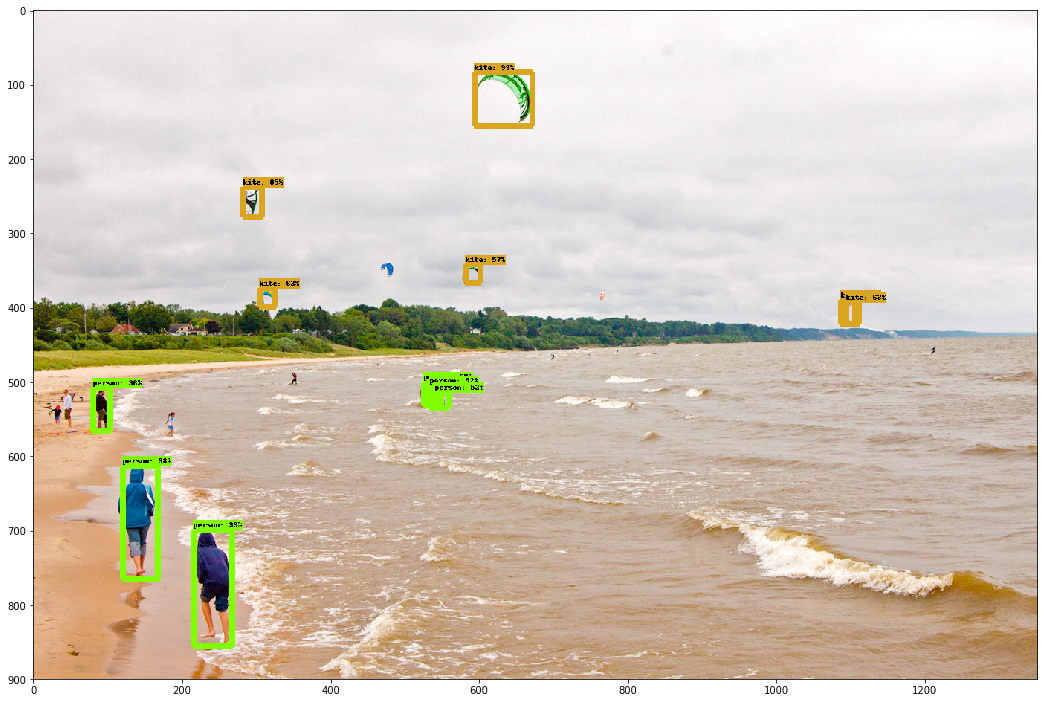

In [5]:
output_im2 = visualize_boxes_and_labels_on_image_array(im2.copy(),
                                                      dict2['detection_boxes'],
                                                      dict2['detection_classes'],
                                                      dict2['detection_scores'],
                                                      category_index,
                                                      instance_masks=dict2.get('detection_masks'),
                                                      use_normalized_coordinates=True,
                                                      line_thickness=8)

print('number of detected object:', dict2['num_detections'])
plt.figure(figsize=(18,18))
plt.imshow(output_im2)

number of detected object: 22


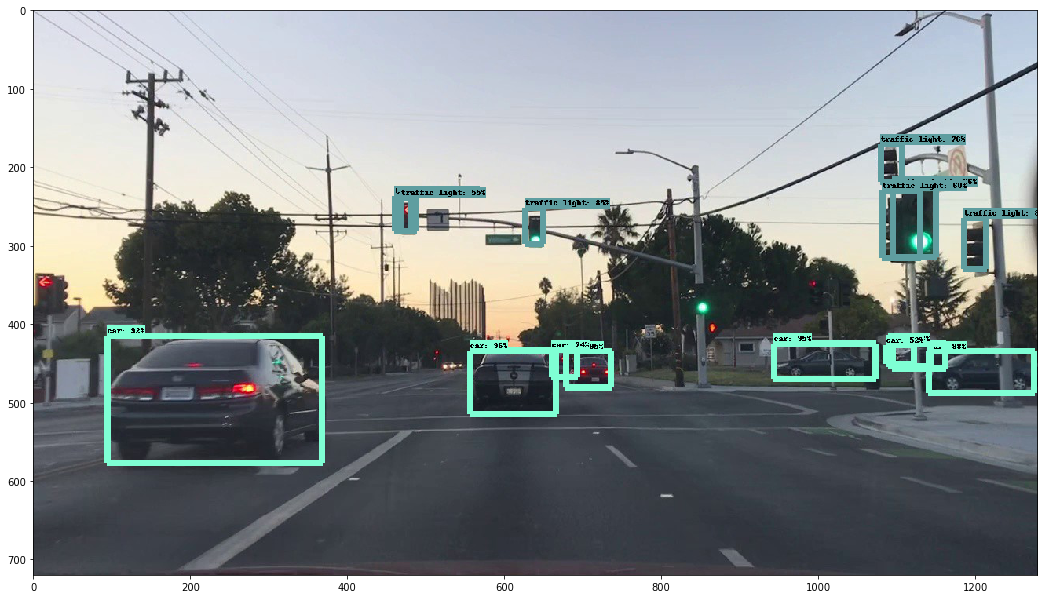

In [6]:
output_im3 = visualize_boxes_and_labels_on_image_array(im3.copy(),
                                                      dict3['detection_boxes'],
                                                      dict3['detection_classes'],
                                                      dict3['detection_scores'],
                                                      category_index,
                                                      instance_masks=dict3.get('detection_masks'),
                                                      use_normalized_coordinates=True,
                                                      line_thickness=8)

print('number of detected object:', dict3['num_detections'])
plt.figure(figsize=(18,18))
plt.imshow(output_im3)

** What do you think?** Is it working good enough? In particular, compare the number of detected object and the number of objects you see in the image.

What could we do to improve our results?

## II. Post processing

We have to perform non max suppression in order to be really consistent. The first step is to compute the Intersection over Union (IoU).

### II.1. IoU

You will implement a function `iou(box1, box2)`, knowing that boxes in the dictionary follow the format `box = [ymin, xmin, ymax, xmax]`.

Computing the IoU may seem easy, but is actually a bit tricky: there are a lot of cases to take into account.

To help you out, consider the following Boxes A and B

![](iou_comput.png)

The first step is to compute the **intersection** of those two boxes. Implement a function `intersection(boxA, boxB)` that computes the intersection of the boxes A and B.

There are 4 distinct cases to take into account:
- the blue box is on the top left of the red one
- the blue box is on the top right of the red one
- the blue box is on the bottom left of the red one
- the blue box is on the bottom right of the red one

Finally, there is one extreme case: when the two boxes have no intersection.

Feel free to take a sheet of paper and try out all those cases to implement the `intersect` function.

In [ ]:
### TODO: implement intersect(box1, box2)
### STRIP_START ###
def intersect(box1, box2):
    xx1 = max(box1[1], box2[1])
    yy1 = max(box1[0], box2[0])
    xx2 = min(box1[3], box2[3])
    yy2 = min(box1[2], box2[2])
    
    return max(0, (xx2-xx1))*max(0, (yy2-yy1))
### STRIP_END ###

Then you can compute the **union** of those two boxes. One can notice that the union is nothing but area of the two boxes, minus the intersection:
$$
union(A, B) = area(A) + area(B) - intersection(A, B)
$$

Now implement the function `union(boxA, boxB)`.

In [12]:
### TODO: implement union(box1, box2)
### STRIP_START ###
def union(box1, box2):
    un = np.abs((box1[2]-box1[0])*(box1[3]-box1[1])) + \
         np.abs((box2[2]-box2[0])*(box2[3]-box2[1])) - \
         intersection(box1, box2)
    return un
### STRIP_END ###

Finally, implement the function `iou(box1, box2)` using the two functions you just implemented.

In [13]:
### TODO: implement iou(box1, box2)
### STRIP_START ###
def iou(box1, box2):
    return intersection(box1, box2)/union(box1, box2)
### STRIP_END ###

To make sure it works, feel free to test your IoU function on several examples.

### II.2. Non max suppression

Now comes the big part: you will have to implement the `non_max_suppression` function.

This function will take as input a dictionary (output of TensorFlow computed in previous challenge), a iou threshold and a detection threshold. This function should output a dictionary containing only the non supressed boxes and detections.

An easier way would be to make two functions. First, implement a function `apply_detection_threshold(detections, detection_threshold)` that removes all the boxes below a given `detection_threshold`.

Then, implement a function `non_max_suppression(detections, iou_threshold, detection_threshold)`. This function applies the detection threshold first with `detection_threshold`. Then, loop over all the boxes, keep the highest score, and remove all the boxes with an IoU below the `iou_threshold`, until there is no box left.

This is a quite complicated function to write, do not worry if you struggle at some point.

In [100]:
### TODO: implement the non_max_suppresion function
### STRIP_START ###

def apply_detection_threshold(detections, detection_threshold):
    picks = []
    
    for i in range(len(detections['detection_scores'])):
        if detections['detection_scores'][i] >= detection_threshold:
            picks.append(i)

    
    output = {'detection_scores': detections['detection_scores'][picks],
              'detection_boxes': detections['detection_boxes'][picks],
              'detection_classes': detections['detection_classes'][picks]}
    
    return output

In [101]:
def non_max_suppression(detections, iou_threshold, detection_threshold):
    
    detections = apply_detection_threshold(detections, detection_threshold)
    
    indices = np.arange(len(detections['detection_boxes']))
    
    
    output_scores = []
    output_boxes = []
    output_classes = []
    
    while len(indices)>0:
        # Get the highest score
        highest_score_idx = detections['detection_scores'].argmax()
        
        # Save the highest score
        output_scores.append(detections['detection_scores'][highest_score_idx])
        output_boxes.append(detections['detection_boxes'][highest_score_idx])
        output_classes.append(detections['detection_classes'][highest_score_idx])
        
        
        # Find out all overlapping boxes
        to_remove = []
        for i in range(len(detections['detection_boxes'])):
            # Check this is not the same box
            if i != highest_score_idx:
                # Check the IoU is above threshold
                if iou(detections['detection_boxes'][highest_score_idx],
                       detections['detection_boxes'][i]) > iou_threshold:
                    # To be removed from the dict
                    to_remove.append(i)

        # Remove them from the dict if any
        if len(to_remove)>0:
            detections['detection_scores'] = np.delete(detections['detection_scores'], to_remove)
            detections['detection_boxes'] = np.delete(detections['detection_boxes'], to_remove, axis=0)
            detections['detection_classes'] = np.delete(detections['detection_classes'], to_remove)
            indices = np.delete(indices, to_remove)


        detections['detection_scores'] = np.delete(detections['detection_scores'], highest_score_idx)
        detections['detection_boxes'] = np.delete(detections['detection_boxes'], highest_score_idx, axis=0)
        detections['detection_classes'] = np.delete(detections['detection_classes'], highest_score_idx)
        indices = np.delete(indices, highest_score_idx)

                            
    output = {'detection_scores': output_scores,
              'detection_boxes': np.array(output_boxes),
              'detection_classes': output_classes}

    return output

### II.3. Visualize new results

Now apply your implemented function `non_max_suppression` and display the new results reusing your previous code. Is it better now? Are there as much boxes as objects?

In [106]:
### TODO: apply non_max_suppression and display the results
### STRIP_START ###
iou_threshold = 0.5
detection_threshold = 0.7
non_max_dict1 = non_max_suppression(dict1, iou_threshold, detection_threshold)
non_max_dict2 = non_max_suppression(dict2, iou_threshold, detection_threshold)
non_max_dict3 = non_max_suppression(dict3, iou_threshold, detection_threshold)
### STRIP_END ###

number of detected object: 2


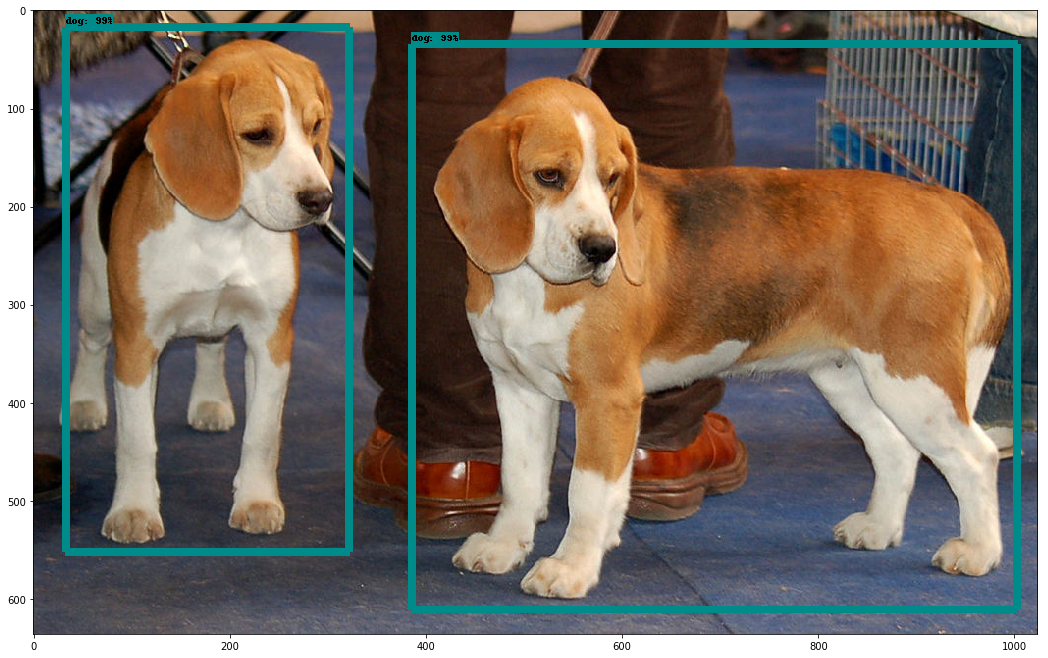

In [107]:
output_im1 = visualize_boxes_and_labels_on_image_array(im1.copy(),
                                                      non_max_dict1['detection_boxes'],
                                                      non_max_dict1['detection_classes'],
                                                      non_max_dict1['detection_scores'],
                                                      category_index,
                                                      #instance_masks=non_max_dict1.get('detection_masks'),
                                                      use_normalized_coordinates=True,
                                                      line_thickness=8)

print('number of detected object:', len(non_max_dict1['detection_classes']))
plt.figure(figsize=(18,18))
plt.imshow(output_im1)

number of detected object: 5


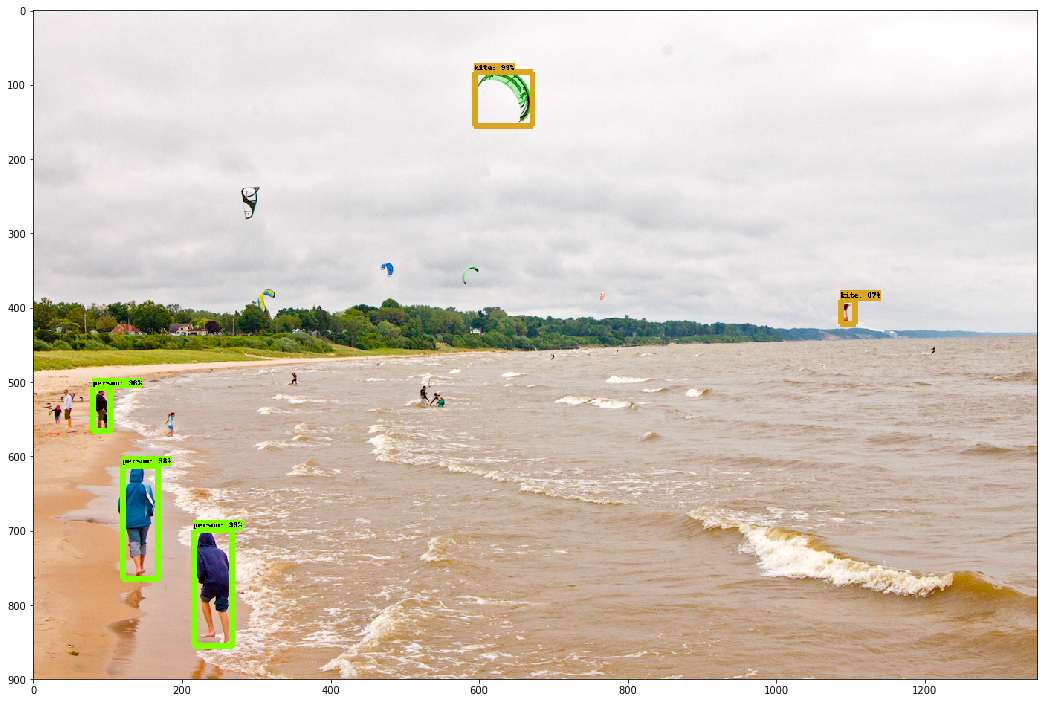

In [108]:
output_im2 = visualize_boxes_and_labels_on_image_array(im2.copy(),
                                                      non_max_dict2['detection_boxes'],
                                                      non_max_dict2['detection_classes'],
                                                      non_max_dict2['detection_scores'],
                                                      category_index,
                                                      instance_masks=non_max_dict2.get('detection_masks'),
                                                      use_normalized_coordinates=True,
                                                      line_thickness=8)

print('number of detected object:', len(non_max_dict2['detection_classes']))
plt.figure(figsize=(18,18))
plt.imshow(output_im2)

number of detected object: 10


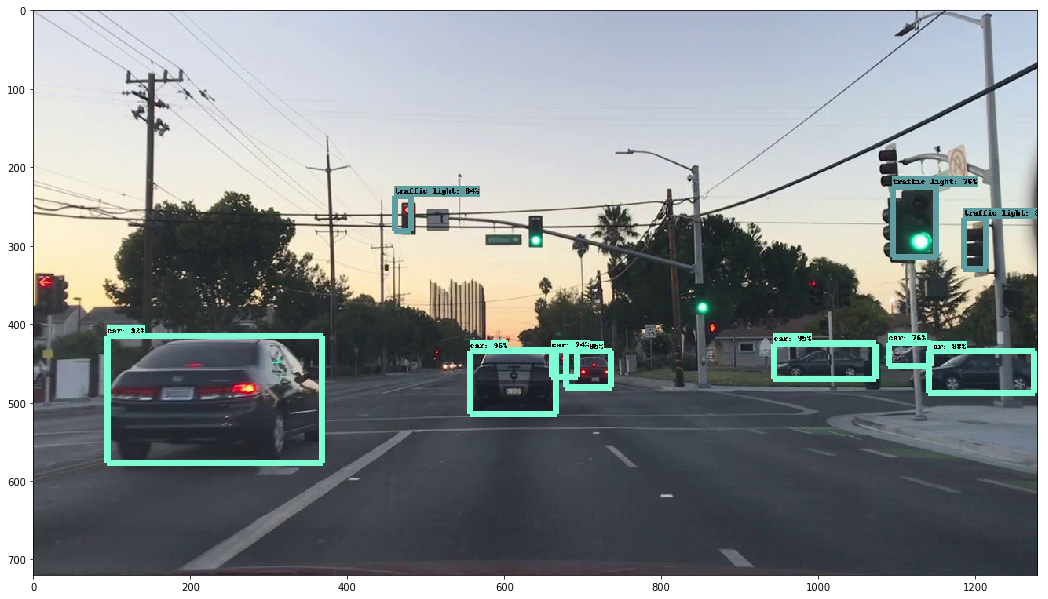

In [109]:
output_im3 = visualize_boxes_and_labels_on_image_array(im3.copy(),
                                                      non_max_dict3['detection_boxes'],
                                                      non_max_dict3['detection_classes'],
                                                      non_max_dict3['detection_scores'],
                                                      category_index,
                                                      instance_masks=non_max_dict3.get('detection_masks'),
                                                      use_normalized_coordinates=True,
                                                      line_thickness=8)

print('number of detected object:', len(non_max_dict3['detection_classes']))
plt.figure(figsize=(18,18))
plt.imshow(output_im3)